### Exploring Housing Data with Python

Inspired by two articles relating to visualization libraries in Python I thought I would try to explore these libraries via in a project with housing data from my home town.

Firstly, the two articles are:

[Introducing Great Tables for Python](https://posit.co/blog/introducing-great-tables-for-python-v0-1-0/)

I've explored styling Pandas DataFrames in the past, but beyond creating heatmaps I haven't been that impressed with the options available. Great Tables was interesting to me because it looked to provide the kind of professional table that I would expect 
to see in a text book. While "gt" is an established package in R, and has only just had its first major release for Python.

[How to Generate FiveThirtyEight Graphs in Python](https://www.dataquest.io/blog/making-538-plots/)

FiveThirtyEight are known for their distinct visual style when presenting political data. This article provides a walk through for achieving similar results with matplotlib. The matplotlib library already has a style that gets close to the FiveThirtyEight style, but this article provides details on how to take it further by styling the axes, titles, data labels and introducing a signature bar.

The data sources used in this project are:

* UK House Price Index, filtered to "Darlington": [Land Registry, UK](https://landregistry.data.gov.uk)
* Annual Survery of Hours and Earnings (ASHE): ["Office for National Statistics](https://www.ons.gov.uk/surveys/informationforbusinesses/businesssurveys/annualsurveyofhoursandearningsashe)

In [15]:
import great_tables as gt
from great_tables import GT, md, html, loc, style
import matplotlib.pyplot as plt
import matplotlib.style as plt_style
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt_style.use("fivethirtyeight")

house_data_source = r"G:\My Drive\Data\#Projects\Python_Price_Paid\ppd_data_Darlington.csv"
earnings_source = r"G:\My Drive\Data\#Projects\Python_Price_Paid\annual_salaries_NE.csv"

house_cols = ["price_paid", "deed_date", "property_type", "new_build", "estate_type", 
        "saon", "paon", "street", "locality", "town", "transaction_category"]

houses = pd.read_csv(house_data_source, usecols=house_cols, dtype_backend="pyarrow", engine="pyarrow")

earnings = pd.read_csv(earnings_source, dtype_backend="pyarrow", engine="pyarrow")

In [16]:
# Tweaking the houses DataFrame

# Very little had to be done here. I mapped the property type and estate type columns to 
# understable terms and filtered out the incomplete year.

property_type_map = {"T": "Terrace", "S": "Semi-detatched", "D": "Detatched", "F": "Flat", "O": "Other"}
estate_type_map = {"F": "Freehold", "L": "Leasehold"}

houses = (houses
        .query("transaction_category != 'B'")
        .assign(
            property_type=lambda df_: df_["property_type"].map(property_type_map).astype("string[pyarrow]"),
            estate_type=lambda df_: df_["estate_type"].map(estate_type_map).astype("string[pyarrow]"),
            deed_date=lambda df_: pd.to_datetime(df_["deed_date"])
            )
        .query("deed_date < '01-01-2023'")
        .loc[:, ["price_paid", "deed_date", "property_type", "new_build", "estate_type", "saon", "paon", "street", "town"]]
        )

In [17]:
# Tweaking the earnings DataFrame

# The only real transformation required here was to replace some commas in the 
# annual salary column to allow it to be a numeric data type.

earnings = (earnings
        .rename(columns=lambda x: x.replace(" ", "_").lower())
        .assign(annual_salary=lambda df_: df_["annual_salary"].str.replace(",", "").astype("int64[pyarrow]"))
        )

In [18]:
# I wanted to see a list of houses where the value had increased more than any others. When originally querying this data
# I found that there were a lot of houses sold shortly following a purchase, perhaps following a short renovation,
# as I was not too interested in these, I filtered them out by specifying that the difference in date sold must be 5 years or more.

df_house = (houses
          .assign(house=lambda df_: np.where(df_["saon"].isna(), df_["paon"], df_["saon"] + " " + df_["paon"]))
          .loc[:,["house", "street", "price_paid", "deed_date"]]
          )

house_price_growth = GT((df_house
          .groupby(['house', 'street']).agg(min_price=("price_paid", "min"),
                                                  max_price=("price_paid", "max")
                                                  )
          .reset_index()
          .merge(df_house, 
               left_on=["house", "street", "min_price"],
               right_on=["house", "street", "price_paid"],
               how="inner")
          .merge(df_house, 
               left_on=["house", "street", "max_price"],
               right_on=["house", "street", "price_paid"],
               how="inner")
          .loc[:,["house", "street", "min_price", "max_price", "deed_date_x", "deed_date_y"]]
          .rename(columns={"deed_date_x": "min_price_date", "deed_date_y": "max_price_date"})
          .query("min_price_date != max_price_date")
          .assign(price_growth=lambda df_: df_["max_price"] - df_["min_price"],
               date_diff_years=lambda df_: ((df_["max_price_date"] - df_["min_price_date"]) / np.timedelta64(365, "D")).round(2),
               )
          .query("date_diff_years >= 5")
          .loc[:,["house", "street", "min_price", "max_price", "min_price_date", "max_price_date", "price_growth"]]  
          .sort_values("price_growth", ascending=False)
          .head(10))
          )

# I found that by following the article, it was quite easy to create a basic table. The methods that this package provides
# allows you to build the visual like a recipe, and by adding lines as you go you have a presentable table.

(house_price_growth
.tab_header(title=html("<center><p><b>House Price Growth Rates, Darlington</b></p></center>"),
            subtitle=html("Top 10 houses by growth rate, filtered for houses held 5 years or more"))
.cols_label(house="House", street="Street Name", min_price="Lowest Price", max_price="Highest Price", price_growth="Price Growth",
            min_price_date="Lowest Price Date", max_price_date="Highest Price Date")
.fmt_currency(columns=["min_price", "max_price", "price_growth"], decimals=0, currency="GBP")
.fmt_date(columns=["min_price_date", "max_price_date"])
.tab_spanner(label="Prices", columns=["min_price", "max_price", "price_growth"])
.cols_align(align="center", columns=["house", "min_price_date", "max_price_date"])
.tab_source_note(source_note=html("Source: HM Land Registry Open Data (<a href>https://landregistry.data.gov.uk</a>)"))
)

GT(_tbl_data=                 house             street  min_price  max_price  \
21143               49          THE GREEN     155000    1130000   
30382      BURDON HALL     BISHOPTON LANE     280000    1200000   
16379               34  CARMEL ROAD SOUTH    1300000    2050000   
15967              323   CONISCLIFFE ROAD     400000    1100000   
9459                20         ABBEY ROAD      59237     725000   
22729               53          THE GREEN      55000     680000   
24087                6        MEADOW RISE     140000     750000   
24088                6        MEADOW RISE     140000     750000   
30797  MILLSTONE HOUSE     STANGARTH LANE     249000     845000   
12932               27        CHURCH LANE     160500     750000   

      min_price_date max_price_date  price_growth  
21143     2002-09-27     2017-11-29        975000  
30382     2002-02-14     2007-12-21        920000  
16379     2004-08-31     2022-05-27        750000  
15967     2001-08-01     2019-06-04        700000  
9459      1999-05-10     2008-12-11        665763  
22729     1999-08-12     2012-02-07        625000  
24087     1999-07-02     2021-08-27        610000  
24088     1999-07-02     2018-08-03        610000  
30797     2003-04-01     2021-06-11        596000  
12932     1996-04-17     2022-01-28        589500  , _body=<great_tables._gt_data.Body object at 0x00000196D652D450>, _boxhead=Boxhead([ColInfo(var='house', type=<ColInfoTypeEnum.default: 1>, column_label='House', column_align='center', column_width=None), ColInfo(var='street', type=<ColInfoTypeEnum.default: 1>, column_label='Street Name', column_align='center', column_width=None), ColInfo(var='min_price', type=<ColInfoTypeEnum.default: 1>, column_label='Lowest Price', column_align='right', column_width=None), ColInfo(var='max_price', type=<ColInfoTypeEnum.default: 1>, column_label='Highest Price', column_align='right', column_width=None), ColInfo(var='price_growth', type=<ColInfoTypeEnum.default: 1>, column_label='Price Growth', column_align='right', column_width=None), ColInfo(var='min_price_date', type=<ColInfoTypeEnum.default: 1>, column_label='Lowest Price Date', column_align='center', column_width=None), ColInfo(var='max_price_date', type=<ColInfoTypeEnum.default: 1>, column_label='Highest Price Date', column_align='center', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=3, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=4, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=5, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=6, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=7, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=8, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=9, group_id=None, rowname=None, group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([SpannerInfo(spanner_id='Prices', spanner_level=0, spanner_label='Prices', spanner_units=None, spanner_pattern=None, vars=['min_price', 'max_price', 'price_growth'], built=None)]), _heading=Heading(title=<great_tables._text.Text object at 0x00000196D3C63550>, subtitle=<great_tables._text.Text object at 0x00000196D6822C90>, preheader=None), _stubhead=None, _source_notes=[<great_tables._text.Text object at 0x00000196D3D1C450>], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x00000196D6820490>, _formats=[<great_tables._gt_data.FormatInfo object at 0x00000196D6845390>, <great_tables._gt_data.FormatInfo object at 0x00000196D6845250>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_captio

In [19]:
top_house_prices = GT((houses
        .sort_values("price_paid", ascending=False)
        .iloc[:10]
        .loc[:,["paon", "street", "price_paid", "deed_date"]]
        ))

(top_house_prices
 .tab_header(title=html("<b>Highest Sold Property Prices, Darlington</b>"),
             subtitle=html("Top 10 prices for houses sold in Darlington since 1995"))
 .cols_label(paon="House", street="Street Name", price_paid="Price", deed_date="Date")
 .fmt_currency(columns="price_paid", decimals=0, currency="GBP")
 .fmt_date(columns="deed_date")
 .tab_source_note(source_note=html("Source: HM Land Registry Open Data (<a href>https://landregistry.data.gov.uk</a>)"))
 )

House,Street Name,Price,Date
MONKEND HALL,,"£2,250,000",2011-04-04
34,CARMEL ROAD SOUTH,"£2,050,000",2022-05-27
VICTORIA HOUSE HOSPITAL,BARTON STREET,"£1,860,000",2001-01-05
HIGH ROCKLIFFE GRANGE,BLIND LANE,"£1,400,000",2022-05-24
BURN HOUSE,,"£1,350,000",2019-05-01
MANFIELD HOUSE,,"£1,325,000",2017-01-20
34,CARMEL ROAD SOUTH,"£1,300,000",2004-08-31
7,BLIND LANE,"£1,241,794",2020-08-14
BURDON HALL,BISHOPTON LANE,"£1,200,000",2007-12-21
49,THE GREEN,"£1,130,000",2017-11-29


In [20]:
# This query was more complex than those created in the previous cells. I limited the data to 2008 onwards,
# one reason was that the table became too long when I presented the entire data set, and then secondly,
# 2008 is a convenient year being the start of the housing market crash.

def flatten(df_):
        cols = ['_'.join(cs) for cs in df_.columns.to_flat_index()]
        df_.columns = cols
        return df_

avg_price_by_type = GT((houses
                .query("deed_date >= 2008")
                .assign(year=lambda df_: df_["deed_date"].dt.year.astype(str))
                .groupby(["year", "property_type"]).agg(avg_price=("price_paid", "mean"))
                .reset_index()
                .assign(avg_price_lagged=lambda df_: df_["avg_price"].shift(4),
                        price_growth=lambda df_: df_["avg_price"] - df_["avg_price_lagged"],
                        price_growth_pct=lambda df_: ((df_["avg_price"] - df_["avg_price_lagged"]) / 
                                                df_["avg_price_lagged"]),
                        cumulative_growth_pct=lambda df_: df_.groupby(["property_type"])["price_growth_pct"].cumsum())
                .loc[:,["year", "property_type", "avg_price", "price_growth_pct"]]
                .set_index(["year", "property_type"])
                .unstack()
                .pipe(flatten)
                .rename(columns=lambda x: x.replace("-", ""))
                .reset_index()
                ))

(avg_price_by_type
 .tab_header(title=html("<b>House Price Growth</b>"),
             subtitle=html("Average prices and growth rates since 2008, by Property Type"))
 .tab_spanner(label=md("*Average Price*"), 
              columns=["avg_price_Flat", "avg_price_Terrace", 
                       "avg_price_Semidetatched", "avg_price_Detatched"])
 .tab_spanner(label=md("*Average Growth Versus Prior Year*"), 
              columns=["price_growth_pct_Flat", "price_growth_pct_Terrace", 
                      "price_growth_pct_Semidetatched", "price_growth_pct_Detatched"])
 .cols_label(
         year=gt.md("**Year**"),
         avg_price_Flat=gt.md("**Flat**"),
         avg_price_Terrace=gt.md("**Terrace**"),
         avg_price_Semidetatched=gt.md("**Semi-Detached**"),
         avg_price_Detatched=gt.md("**Detached**"),
         price_growth_pct_Flat=gt.md("**Flat**"),
         price_growth_pct_Terrace=gt.md("**Terrace**"),
         price_growth_pct_Semidetatched=gt.md("**Semi-Detached**"),
         price_growth_pct_Detatched=gt.md("**Detached**"))
 .fmt_currency(columns=["avg_price_Detatched", 
                        "avg_price_Flat", 
                        "avg_price_Semidetatched", 
                        "avg_price_Terrace"], 
                        decimals=0, currency="GBP")
 .fmt_percent(columns=["price_growth_pct_Detatched", 
                       "price_growth_pct_Flat", 
                       "price_growth_pct_Semidetatched", 
                       "price_growth_pct_Terrace"])
 .tab_style(
        style=[
            style.text(weight="bold", size="12px")
        ],
        locations=loc.body(columns="year")
        )
 .tab_style(
         style=style.text(size="12px"), 
         locations=loc.body(columns=["avg_price_Flat", "avg_price_Terrace", 
                                     "avg_price_Semidetatched", "avg_price_Detatched",
                                     "price_growth_pct_Flat", "price_growth_pct_Terrace", 
                                     "price_growth_pct_Semidetatched", "price_growth_pct_Detatched"])
)
 .data_color(
        columns=["price_growth_pct_Detatched", "price_growth_pct_Flat", 
                 "price_growth_pct_Semidetatched", "price_growth_pct_Terrace"],
        domain=[0,0.5],
        palette=["#b7e4c7", "#40916c", "#1b4332"],
        na_color="white"
    )
 .tab_source_note(source_note=html("Source: HM Land Registry Open Data (<a href>https://landregistry.data.gov.uk</a>)"))
 )

GT(_tbl_data=    year  avg_price_Detatched  avg_price_Flat  avg_price_Semidetatched  \
0   2008        237941.871595   121627.321782            143554.738281   
1   2009        225127.533937   113886.989899              138729.9274   
2   2010        231067.979339   123755.360465            139133.651709   
3   2011        226942.550926   119386.738636            135741.101053   
4   2012        222590.838298   102825.144928            132578.015317   
5   2013        225770.691756   104065.146067            133040.755396   
6   2014        239976.918987   110582.053571            138385.709576   
7   2015        252527.887531   100880.097087            140276.177294   
8   2016        231357.411429   101367.394958            150921.186414   
9   2017        257027.850416   141044.369369            148120.990196   
10  2018        256338.671053   115956.681818            151141.561905   
11  2019        278745.858942   128869.761364             149406.81997   
12  2020        278595.806941   103728.471429            153345.244898   
13  2021        302440.906902    110093.65493             166057.31929   
14  2022        333649.201373   116232.879699            180051.186813   

    avg_price_Terrace  price_growth_pct_Detatched  price_growth_pct_Flat  \
0         107182.3829                        <NA>                   <NA>   
1       103802.729167                   -0.053855               -0.06364   
2       107150.486284                    0.026387               0.086651   
3       103752.520942                   -0.017854                -0.0353   
4        96193.785548                   -0.019175              -0.138722   
5       104856.477876                    0.014286               0.012059   
6        106575.68609                    0.062923               0.062623   
7       107137.578207                    0.052301              -0.087735   
8       112969.453263                   -0.083834                0.00483   
9       110315.169524                    0.110956               0.391418   
10      109881.238835                   -0.002681              -0.177871   
11      110905.515337                    0.087412               0.111361   
12      119685.864476                   -0.000538              -0.195091   
13      128004.905109                     0.08559               0.061364   
14      132269.767361                    0.103188               0.055764   

    price_growth_pct_Semidetatched  price_growth_pct_Terrace  
0                             <NA>                      <NA>  
1                         -0.03361                 -0.031532  
2                          0.00291                  0.032251  
3                        -0.024383                 -0.031712  
4                        -0.023302                 -0.072854  
5                          0.00349                  0.090055  
6                         0.040175                  0.016396  
7                         0.013661                  0.005272  
8                         0.075886                  0.054434  
9                        -0.018554                 -0.023496  
10                        0.020393                 -0.003934  
11                       -0.011478                  0.009322  
12                         0.02636                   0.07917  
13                        0.082898                  0.069507  
14                        0.084271                  0.033318  , _body=<great_tables._gt_data.Body object at 0x00000196D38D7D90>, _boxhead=Boxhead([ColInfo(var='year', type=<ColInfoTypeEnum.default: 1>, column_label=<great_tables._text.Text object at 0x00000196D37A7090>, column_align='right', column_width=None), ColInfo(var='avg_price_Flat', type=<ColInfoTypeEnum.default: 1>, column_label=<great_tables._text.Text object at 0x00000196D3617190>, column_align='center', column_width=None), ColInfo(var='avg_price_Terrace', type=<ColInfoTypeEnum.default: 1>, column_label=<great_tables._text.Text object at 0x00000196D3CA7390>, column_align=

In [21]:
# Introducing earnings into the house price data means that I can show average salary multiples
# against the average prices of different house types. 

current_affordability = GT((houses
        .assign(year=lambda df_: df_["deed_date"].dt.year)
        .query("year == 2022")
        .groupby(["year", "property_type"]).agg(avg_price=("price_paid", "mean"),
                                                count_sold=("property_type", "count"))
        .reset_index()
        .merge(earnings, left_on="year", right_on="year", how="left")
        .assign(salary_multiple=lambda df_: df_["avg_price"] / df_["annual_salary"])
        .set_index("property_type")
        .loc[:,["avg_price", "count_sold", "salary_multiple"]]
        .reset_index()
        .sort_values("avg_price", ascending=True)
        ))

(current_affordability
 .tab_header(title=html("<b>House Price Affordability, 2022</b>"),
             subtitle=html("Average prices by house type compared to average region salary (£29,816)"))
 .cols_label(property_type="Property Type", avg_price="Average Price", count_sold="Quantity Sold", salary_multiple="Salary Multiple")
 .fmt_currency(columns=["avg_price"], decimals=0, currency="GBP")
 .fmt_number(columns=["salary_multiple"], decimals=2)
 .cols_align(align="center", columns="count_sold")
 .tab_source_note(source_note=html("Source: HM Land Registry Open Data (<a href>https://landregistry.data.gov.uk</a>)"))
 .tab_source_note(source_note=html("Source: ONS, Annual Survey of Hours and Earnings, 2023 (<a href>https://ons.gov.uk</a>)"))
 )

GT(_tbl_data=    property_type      avg_price  count_sold  salary_multiple
1            Flat  116232.879699         133         3.898339
3         Terrace  132269.767361         576         4.436201
2  Semi-detatched  180051.186813         637         6.038744
0       Detatched  333649.201373         437        11.190274, _body=<great_tables._gt_data.Body object at 0x00000196D6822010>, _boxhead=Boxhead([ColInfo(var='property_type', type=<ColInfoTypeEnum.default: 1>, column_label='Property Type', column_align='left', column_width=None), ColInfo(var='avg_price', type=<ColInfoTypeEnum.default: 1>, column_label='Average Price', column_align='center', column_width=None), ColInfo(var='count_sold', type=<ColInfoTypeEnum.default: 1>, column_label='Quantity Sold', column_align='center', column_width=None), ColInfo(var='salary_multiple', type=<ColInfoTypeEnum.default: 1>, column_label='Salary Multiple', column_align='center', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=3, group_id=None, rowname=None, group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([]), _heading=Heading(title=<great_tables._text.Text object at 0x00000196D0CFA8D0>, subtitle=<great_tables._text.Text object at 0x00000196D38E1F50>, preheader=None), _stubhead=None, _source_notes=[<great_tables._text.Text object at 0x00000196D37ADA50>, <great_tables._text.Text object at 0x00000196D3984810>], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x00000196D652CD10>, _formats=[<great_tables._gt_data.FormatInfo object at 0x00000196D3C210D0>, <great_tables._gt_data.FormatInfo object at 0x00000196D37ADA90>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=None), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False

In [22]:
house_aggregates = GT((houses
        .assign(year=lambda df_: df_["deed_date"].dt.year)
        .query("year >= 2020")
        .groupby(["year", "property_type"])
        .agg(
            highest_price=("price_paid", "max"),
            lowest_price=("price_paid", "min"),
            average_price=("price_paid", "mean"),
            count_sold=("property_type", "count")
            )
        .reset_index()
        .astype({"year": "str"})
        ), rowname_col="property_type", groupname_col="year")

(house_aggregates
 .tab_header(title=html("<b>House Price Analysis (THE COVID YEARS)</b>"),
             subtitle=html("Comparison of Highest, Lowest, and Average Prices, and Number of Houses Sold by House Type"))
 .cols_label(highest_price="Highest Price", lowest_price="Lowest Price", average_price="Average Price", count_sold="Number Sold")
 .fmt_currency(columns=["highest_price", "lowest_price", "average_price"], decimals=0, currency="GBP")
 .cols_align(align="center", columns="count_sold")
 .tab_source_note(source_note=html("Source: HM Land Registry Open Data (<a href>https://landregistry.data.gov.uk</a>)"))
 .tab_source_note(source_note=html("Source: ONS, Annual Survey of Hours and Earnings, 2023 (<a href>https://ons.gov.uk</a>)"))
 )

GT(_tbl_data=    year   property_type  highest_price  lowest_price  average_price  \
0   2020       Detatched        1241794         95000  278595.806941   
1   2020            Flat         319500         47500  103728.471429   
2   2020  Semi-detatched         499999         61000  153345.244898   
3   2020         Terrace         615000         37500  119685.864476   
4   2021       Detatched        1100000        122000  302440.906902   
5   2021            Flat         535000         49500   110093.65493   
6   2021  Semi-detatched         644000         40000   166057.31929   
7   2021         Terrace         575000         20000  128004.905109   
8   2022       Detatched        2050000        128000  333649.201373   
9   2022            Flat         520000         50000  116232.879699   
10  2022  Semi-detatched         750000         60000  180051.186813   
11  2022         Terrace         640000         39995  132269.767361   

    count_sold  
0          461  
1           70  
2          588  
3          487  
4          623  
5          142  
6          902  
7          685  
8          437  
9          133  
10         637  
11         576  , _body=<great_tables._gt_data.Body object at 0x00000196D3B307D0>, _boxhead=Boxhead([ColInfo(var='year', type=<ColInfoTypeEnum.row_group: 3>, column_label='year', column_align='right', column_width=None), ColInfo(var='property_type', type=<ColInfoTypeEnum.stub: 2>, column_label='property_type', column_align='left', column_width=None), ColInfo(var='highest_price', type=<ColInfoTypeEnum.default: 1>, column_label='Highest Price', column_align='right', column_width=None), ColInfo(var='lowest_price', type=<ColInfoTypeEnum.default: 1>, column_label='Lowest Price', column_align='right', column_width=None), ColInfo(var='average_price', type=<ColInfoTypeEnum.default: 1>, column_label='Average Price', column_align='center', column_width=None), ColInfo(var='count_sold', type=<ColInfoTypeEnum.default: 1>, column_label='Number Sold', column_align='center', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id='2020', rowname='Detatched', group_label=None, built=False), RowInfo(rownum_i=1, group_id='2020', rowname='Flat', group_label=None, built=False), RowInfo(rownum_i=2, group_id='2020', rowname='Semi-detatched', group_label=None, built=False), RowInfo(rownum_i=3, group_id='2020', rowname='Terrace', group_label=None, built=False), RowInfo(rownum_i=4, group_id='2021', rowname='Detatched', group_label=None, built=False), RowInfo(rownum_i=5, group_id='2021', rowname='Flat', group_label=None, built=False), RowInfo(rownum_i=6, group_id='2021', rowname='Semi-detatched', group_label=None, built=False), RowInfo(rownum_i=7, group_id='2021', rowname='Terrace', group_label=None, built=False), RowInfo(rownum_i=8, group_id='2022', rowname='Detatched', group_label=None, built=False), RowInfo(rownum_i=9, group_id='2022', rowname='Flat', group_label=None, built=False), RowInfo(rownum_i=10, group_id='2022', rowname='Semi-detatched', group_label=None, built=False), RowInfo(rownum_i=11, group_id='2022', rowname='Terrace', group_label=None, built=False)]), _row_groups=['2020', '2021', '2022'], _group_rows=GroupRows([GroupRowInfo(group_id='2020', group_label=None, indices=[0, 1, 2, 3], has_summary_rows=False, summary_row_side=None), GroupRowInfo(group_id='2021', group_label=None, indices=[4, 5, 6, 7], has_summary_rows=False, summary_row_side=None), GroupRowInfo(group_id='2022', group_label=None, indices=[8, 9, 10, 11], has_summary_rows=False, summary_row_side=None)]), _spanners=Spanners([]), _heading=Heading(title=<great_tables._text.Text object at 0x00000196D3938090>, subtitle=<great_tables._text.Text object at 0x00000196D67B9E90>, preheader=None), _stubhead=None, _source_notes=[<great_tables._text.Text object at 0x00000196D6851AD0>, <great_tables._text.Text object at 0x00000196D68626D0>], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x00000196D66D3910>, _formats=[<great_t

Text(1997.2, -23000, 'Source: HM Land Registry Open Data (https://landregistry.data.gov.uk)')

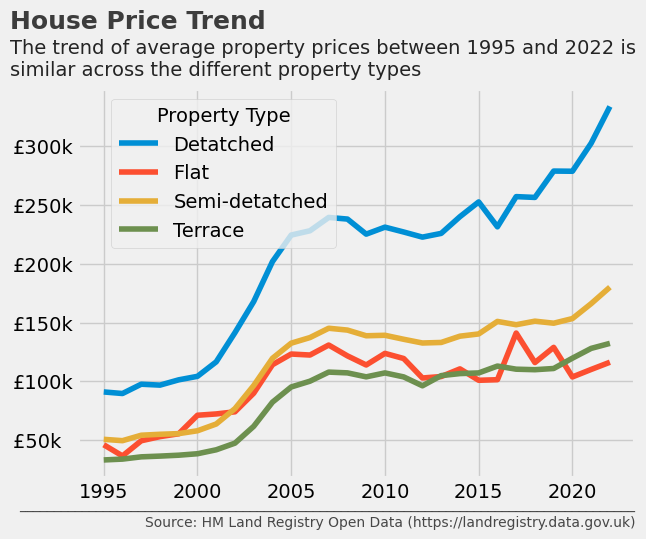

In [23]:
property_type_price_by_year = (houses
                .assign(year=lambda df_: df_["deed_date"].dt.year)
                .groupby(["year", "property_type"]).agg(avg_price=("price_paid", "mean"))
                .reset_index()
                )

property_type_growth_by_year = (houses
                .assign(year=lambda df_: df_["deed_date"].dt.year)
                .groupby(["year", "property_type"]).agg(avg_price=("price_paid", "mean"))
                .reset_index()
                .assign(avg_price_lagged=lambda df_: df_["avg_price"].shift(4),
                        price_growth=lambda df_: df_["avg_price"] - df_["avg_price_lagged"],
                        price_growth_pct=lambda df_: ((df_["avg_price"] - df_["avg_price_lagged"]) / 
                                                df_["avg_price_lagged"]).mul(100).round(2),
                        cumulative_growth_pct=lambda df_: df_.groupby(["property_type"])["price_growth_pct"].cumsum())
)

avg_prices_by_property_type = sns.lineplot(data=property_type_price_by_year, x="year", y="avg_price", hue="property_type")

avg_prices_by_property_type.set_yticks([50000, 100000, 150000, 200000, 250000, 300000])
avg_prices_by_property_type.set_yticklabels(['£50k  ', '£100k', '£150k', '£200k', '£250k', '£300k'])

avg_prices_by_property_type.xaxis.label.set_visible(False)
avg_prices_by_property_type.yaxis.label.set_visible(False)

sns.move_legend(avg_prices_by_property_type, loc=1, bbox_to_anchor=(.48, 1), title='Property Type')

avg_prices_by_property_type.text(x=1990, y=400000,
                       s = "House Price Trend", fontsize=18, weight="bold", alpha=0.75)
avg_prices_by_property_type.text(x=1990, y=360000,
                       s = "The trend of average property prices between 1995 and 2022 is\nsimilar across the different property types", fontsize=14, alpha=0.85)
avg_prices_by_property_type.text(x = 1990.5, y = -9000,
    s = "________________________________________________________________________________________", fontsize=10, alpha=0.7)
avg_prices_by_property_type.text(x = 1997.2, y = -23000,
    s = "Source: HM Land Registry Open Data (https://landregistry.data.gov.uk)", fontsize=10, alpha=0.7)

Text(1998.4, -55, 'Source: HM Land Registry Open Data (https://landregistry.data.gov.uk)')

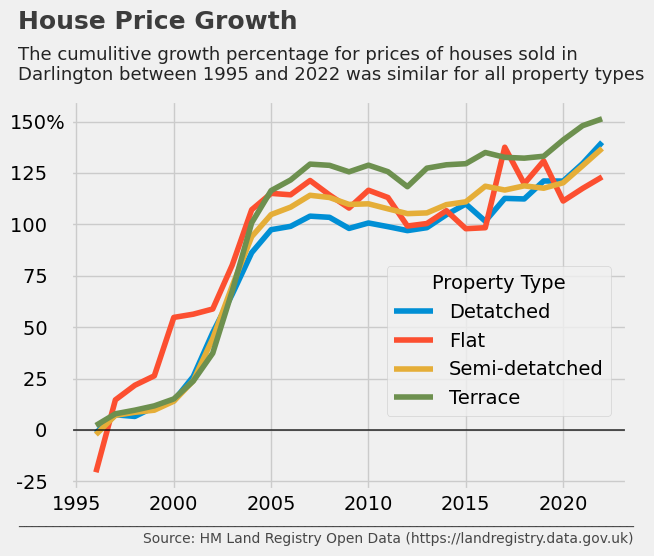

In [24]:
cumulative_growth_by_property_type = sns.lineplot(data=property_type_growth_by_year.iloc[4:,:], 
                                 x="year", y="cumulative_growth_pct", hue="property_type")

cumulative_growth_by_property_type.set_yticks([-25, 0, 25, 50, 75, 100, 125, 150])
cumulative_growth_by_property_type.set_yticklabels(['-25   ', '0   ', '25   ', '50   ', '75   ', '100   ', '125   ', '150%'])
cumulative_growth_by_property_type.xaxis.label.set_visible(False)
cumulative_growth_by_property_type.yaxis.label.set_visible(False)
cumulative_growth_by_property_type.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

sns.move_legend(cumulative_growth_by_property_type, loc=2, bbox_to_anchor=(.55, .6), title='Property Type')

cumulative_growth_by_property_type.text(x=1992, y=195,
                       s = "House Price Growth", fontsize=18, weight="bold", alpha=0.75)
cumulative_growth_by_property_type.text(x=1992, y=170,
                       s = "The cumulitive growth percentage for prices of houses sold in\nDarlington between 1995 and 2022 was similar for all property types", fontsize=13, alpha=0.85)
cumulative_growth_by_property_type.text(x = 1992, y = -46,
    s = "________________________________________________________________________________________", fontsize=10, alpha=0.7)
cumulative_growth_by_property_type.text(x = 1998.4, y = -55,
    s = "Source: HM Land Registry Open Data (https://landregistry.data.gov.uk)", fontsize=10, alpha=0.7)

Text(2006.6, 3.95, 'Terrace')

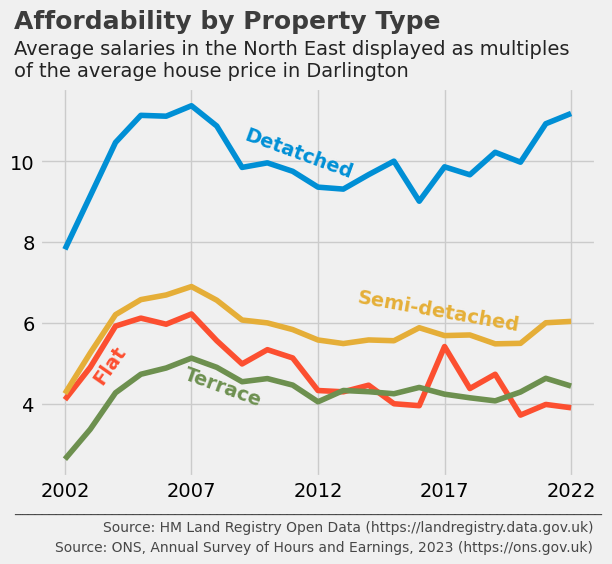

In [25]:
avg_salary_analysis_by_type = (houses
        .query("deed_date >= 2002")
        .assign(year=lambda df_: df_["deed_date"].dt.year)
        .groupby(["year", "property_type"]).agg(avg_price=("price_paid", "mean"))
        .reset_index()
        .merge(earnings, left_on="year", right_on="year", how="inner")
        .assign(
            pay_multiple=lambda df_: (df_["avg_price"] / df_["annual_salary"])
            )
        )

avg_salary_analysis_by_type = sns.lineplot(data=avg_salary_analysis_by_type, 
                                 x="year", y="pay_multiple", hue="property_type", legend=False)

plt.xticks(list(range(2002,2023, 5)))

avg_salary_analysis_by_type.xaxis.label.set_visible(False)
avg_salary_analysis_by_type.yaxis.label.set_visible(False)

avg_salary_analysis_by_type.text(x=2000, y=13.3,
                       s = "Affordability by Property Type", fontsize=18, weight="bold", alpha=0.75)
avg_salary_analysis_by_type.text(x=2000, y=12.1,
                       s = "Average salaries in the North East displayed as multiples\nof the average house price in Darlington", fontsize=14, alpha=0.85)
avg_salary_analysis_by_type.text(x = 2000, y = 1.3,
    s = "____________________________________________________________________________________", fontsize=10, alpha=0.7)
avg_salary_analysis_by_type.text(x = 2003.5, y = 0.85,
    s = "Source: HM Land Registry Open Data (https://landregistry.data.gov.uk)", fontsize=10, alpha=0.7)
avg_salary_analysis_by_type.text(x = 2001.6, y = 0.35,
    s = "Source: ONS, Annual Survey of Hours and Earnings, 2023 (https://ons.gov.uk)", fontsize=10, alpha=0.7)

avg_salary_analysis_by_type.text(x=2009, y=9.6, s="Detatched", weight="bold", rotation=-20, color="#0090D6")
avg_salary_analysis_by_type.text(x=2003, y=4.5, s="Flat", weight="bold", rotation=55, color="#FD4E30")
avg_salary_analysis_by_type.text(x=2013.5, y=5.8, s="Semi-detached", weight="bold", rotation=-10, color="#E5AF37")
avg_salary_analysis_by_type.text(x=2006.6, y=3.95, s="Terrace", weight="bold", rotation=-20, color="#6D9050")

In [ ]:
# While we are able to copy and paste any Great_Table output to other programs for distribution, such as Word, Outlook, PowerPoint, etc.
# The library itself does not include any methods to export results to html, or image currently. Below I've created my own, which could
# be wrapped into a function to provide the same functionality. It has some limitations, and I believe copying and pasting will likely
# be the standard use for me, it at least provides the option.

from html2image import Html2Image
from IPython.core.display import HTML

html_file_path = r"C:\Scripts\test.html"

# Get the HTML content from the displayed output
html_content = HTML(gt._repr_html_()).data

# Save the HTML content to a file
with open(html_file_path, "w") as f:
    f.write(html_content)

# Instantiate Html2Image
hti = Html2Image()

# Screenshot an HTML file
hti.screenshot(
    html_file=html_file_path, save_as="test.png"
)